In [1]:
from sqlalchemy.ext.asyncio import create_async_engine, AsyncSession
from sqlalchemy.orm import sessionmaker
from sqlalchemy.future import select
from statsmodels.api import OLS
import pandas as pd
from sqlalchemy import case, func
from fleecekmbackend.db.models import Author, Answer, Rating
from fleecekmbackend.core.config import DATABASE_URL
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Setting up the async engine and session
engine = create_async_engine(DATABASE_URL, echo=False)
async_session = sessionmaker(engine, expire_on_commit=False, class_=AsyncSession)

async def fetch_data(model_name, sample_size=10000):
    async with async_session() as session:
        # Define a subquery for authors using the specific model
        author_subquery = select(Author.id).where(Author.model == model_name).subquery()

        # Define a subquery for questions having both 'ic' and 'zs' answers from the same author
        answer_subquery = select(Answer.question_id).join(
            author_subquery, Answer.author_id == author_subquery.c.id
        ).group_by(
            Answer.question_id, Answer.author_id
        ).having(
            func.count(Answer.id) >= 2,  # Assuming at least one 'ic' and one 'zs'
            func.sum(case((Answer.setting == 'ic', 1), else_=0)) > 0,
            func.sum(case((Answer.setting == 'zs', 1), else_=0)) > 0
        ).subquery()

        main_query = (select(Answer.question_id, Answer.setting, Rating.value)
                        .join(Rating, Answer.id == Rating.answer_id)
                        .join(answer_subquery, Answer.question_id == answer_subquery.c.question_id)
                        .select_from(Answer)
                        .order_by(Answer.question_id))

        # Main query to select answers and their ratings
        results_ic = await session.execute(
            main_query.where(Answer.setting == 'ic').limit(sample_size)
        )
        results_zs = await session.execute(
            main_query.where(Answer.setting == 'zs').limit(sample_size)
        )
        return results_ic.all() + results_zs.all()

def prepare_data(data):
    # Create a DataFrame
    df = pd.DataFrame(data, columns=['question_id', 'setting', 'rating_value'])
    
    # Convert 'setting' to a binary indicator variable for regression analysis
    df['setting_ind'] = df['setting'].apply(lambda x: 1 if x == 'ic' else 0)
    return df

async def analyze_model(model_name):
    data = await fetch_data(model_name)
    prepared_data = prepare_data(data)
    
    # Perform regression analysis
    Y = prepared_data['rating_value']
    X = prepared_data[['setting_ind']]
    X = sm.add_constant(X)  # adding a constant
    model = OLS(Y, X).fit()
    print(f"Regression Analysis for {model_name}")
    print(model.summary())
    return model, prepared_data


In [2]:
llama3_regression_model, llama3_data = await analyze_model("meta-llama/Meta-Llama-3-70B-Instruct")

Regression Analysis for meta-llama/Meta-Llama-3-70B-Instruct
                            OLS Regression Results                            
Dep. Variable:           rating_value   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                 1.014e+04
Date:                Thu, 16 May 2024   Prob (F-statistic):               0.00
Time:                        16:37:39   Log-Likelihood:                -32422.
No. Observations:               20000   AIC:                         6.485e+04
Df Residuals:                   19998   BIC:                         6.486e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

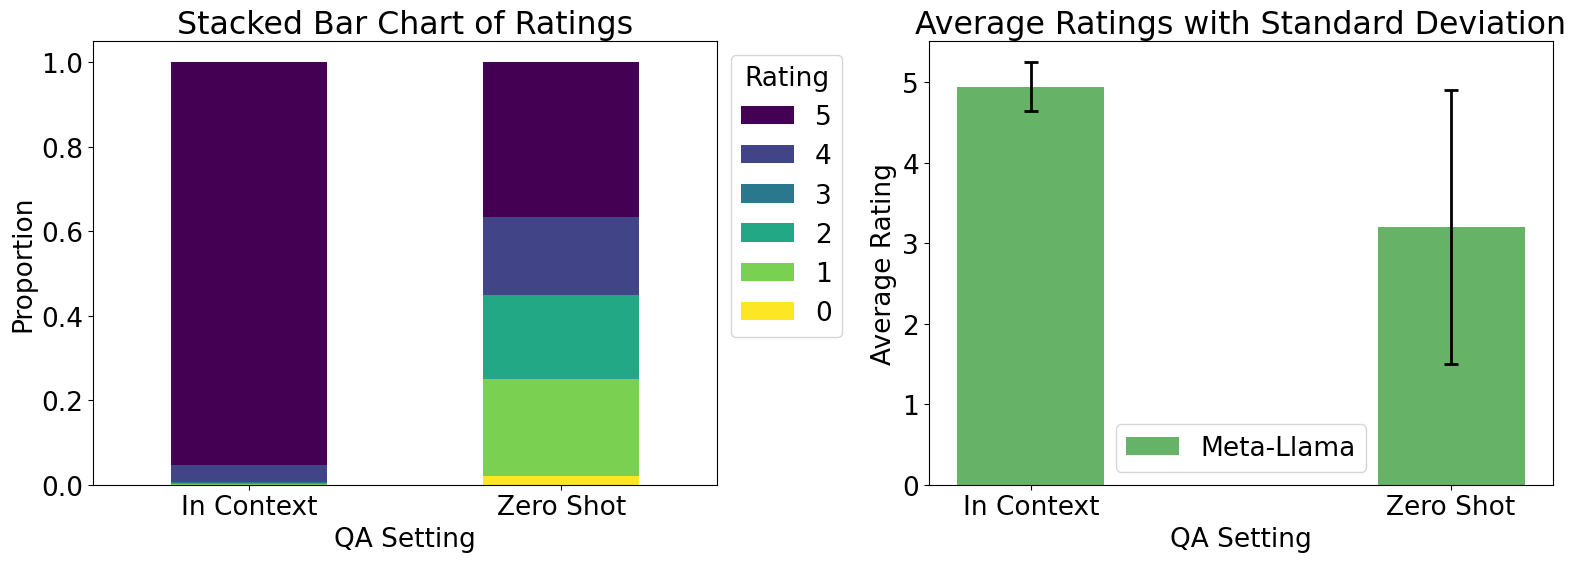

In [5]:
import matplotlib.pyplot as plt
import numpy as np

async def plot_model_results(data_meta):
    unique_ratings = {}
    model_name = 'Meta-Llama'
    unique_ratings[model_name] = data_meta['rating_value'].nunique()
    max_unique_ratings = max(unique_ratings.values())
    colors = plt.cm.viridis(np.linspace(1, 0, max_unique_ratings))

    plt.rcParams.update({'font.size': 19})

    # Initialize subplot for two graphs side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Normalize and plot 100% Stacked Bar Chart for Meta-Llama
    counts = data_meta.groupby(['setting', 'rating_value']).size().unstack(fill_value=0)
    proportions = counts.divide(counts.sum(axis=1), axis=0)
    proportions.sort_index(ascending=True).plot(kind='bar', stacked=True, color=colors, ax=axes[0])
    axes[0].set_title(f'Stacked Bar Chart of Ratings')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xlabel('QA Setting')
    axes[0].set_xticklabels(['In Context', 'Zero Shot'], rotation=0)
    axes[0].legend(title='Rating', bbox_to_anchor=(1.0, 1.0), reverse=True)

    # Bar graph of average ratings with variance as error bars for Meta-Llama
    index = np.arange(2) 
    bar_width = 0.35
    error_config = {'capsize': 5, 'elinewidth': 2, 'markeredgewidth': 2}

    # Get means and variances
    means_meta = data_meta.groupby('setting')['rating_value'].mean()
    variances_meta = data_meta.groupby('setting')['rating_value'].var()

    # Bars for Meta-Llama
    axes[1].bar(index, means_meta, bar_width, yerr=np.sqrt(variances_meta), label='Meta-Llama',
                error_kw=error_config, color='green', alpha=0.6)

    axes[1].set_xlabel('QA Setting')
    axes[1].set_ylabel('Average Rating')
    axes[1].set_title('Average Ratings with Standard Deviation')
    axes[1].set_xticks(index)
    axes[1].set_xticklabels(['In Context', 'Zero Shot'])
    axes[1].legend()

    plt.tight_layout()
    plt.show()

await plot_model_results(llama3_data)
